# 과일 이미지 데이터 비지도 학습

## 데이터 가져오기

In [1]:
import numpy as np

fruits = np.load('./data/fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100)

## 주성분 분석 후 구조 확인

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(fruits_2d)

print(pca.components_.shape)

(50, 10000)


## 주성분 분석 후 이미지 출력

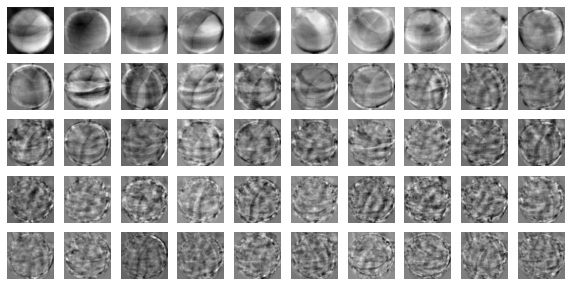

In [3]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
    n = len(arr)    # n은 샘플 개수입니다
    # 한 줄에 10개씩 이미지를 그립니다. 샘플 개수를 10으로 나누어 전체 행 개수를 계산합니다. 
    rows = int(np.ceil(n/10))
    # 행이 1개 이면 열 개수는 샘플 개수입니다. 그렇지 않으면 10개입니다.
    cols = n if rows < 2 else 10
    fig, axs = plt.subplots(rows, cols, 
                            figsize=(cols*ratio, rows*ratio), squeeze=False)
    for i in range(rows):
        for j in range(cols):
            if i*10 + j < n:    # n 개까지만 그립니다.
                axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
            axs[i, j].axis('off')
    plt.show()
    
draw_fruits(pca.components_.reshape(-1, 100, 100))

## 데이터 구조 확인

In [4]:
print(fruits_2d.shape)

(300, 10000)


In [5]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


## 원본 데이터 재구성

In [6]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


## 복원된 데이터 출력

In [7]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)

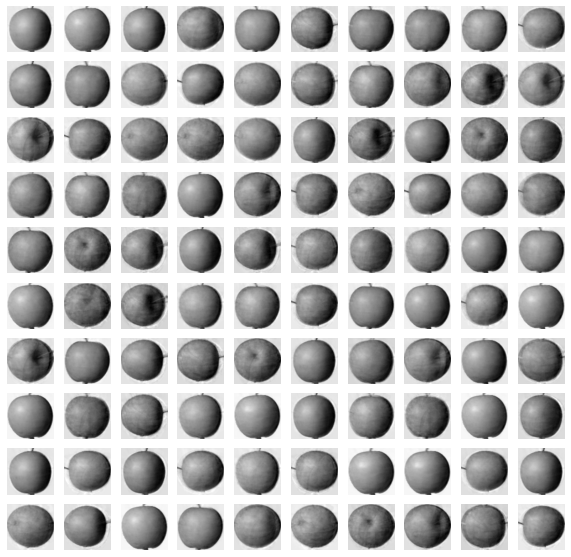

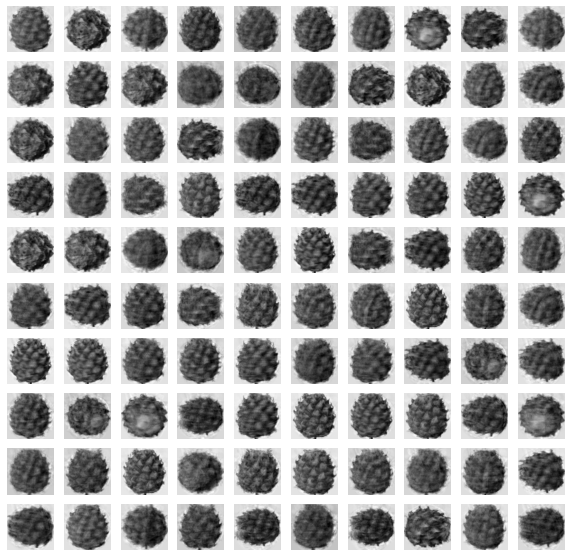

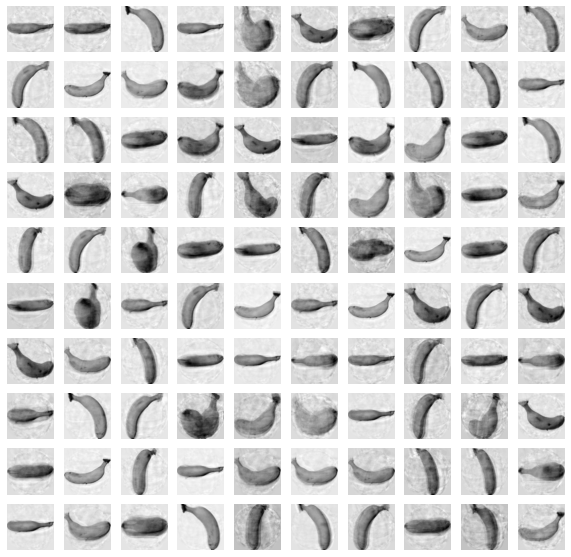

In [8]:
for start in [0, 100, 200]:
    draw_fruits(fruits_reconstruct[start:start+100])
    print("\n")

## 설명된 분산 확인

In [9]:
print(np.sum(pca.explained_variance_ratio_))

0.9214944913014067


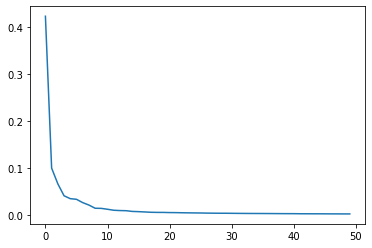

In [10]:
plt.plot(pca.explained_variance_ratio_)

## 주성분 분석 후 분류 알고리즘 적용

### Logistic Regression 적용

In [11]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

target = np.array([0] * 100 + [1] * 100 + [2] * 100)

In [12]:
from sklearn.model_selection import cross_validate

scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
0.29954328536987307


In [13]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.02099165916442871


## 설명된 분산의 비율로 주성분 분석

### 50% 적용

In [14]:
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

print(pca.n_components_)

2


In [15]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [16]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.03456339836120605


/Users/adam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/adam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

## 차원 축소된 데이터를 이용한 클러스터링

In [17]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)

print(np.unique(km.labels_, return_counts=True))

(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


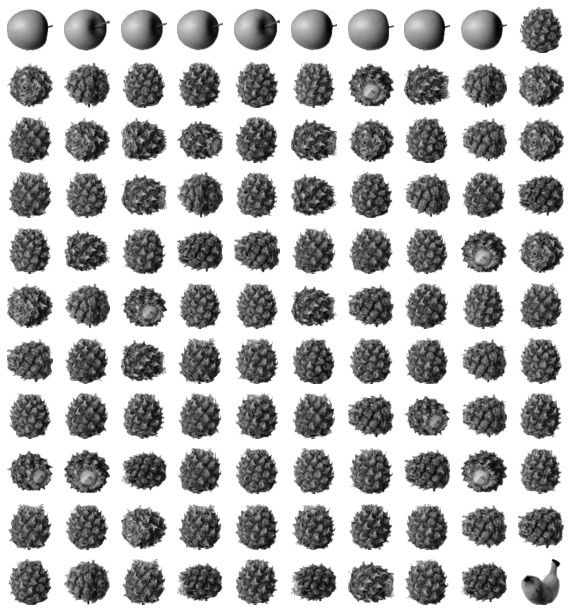

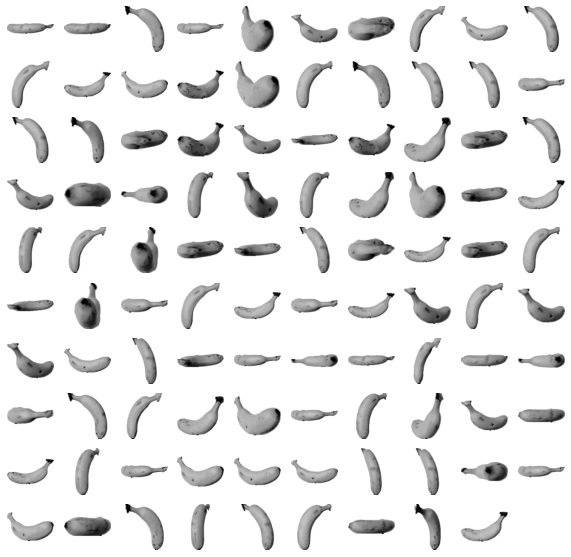

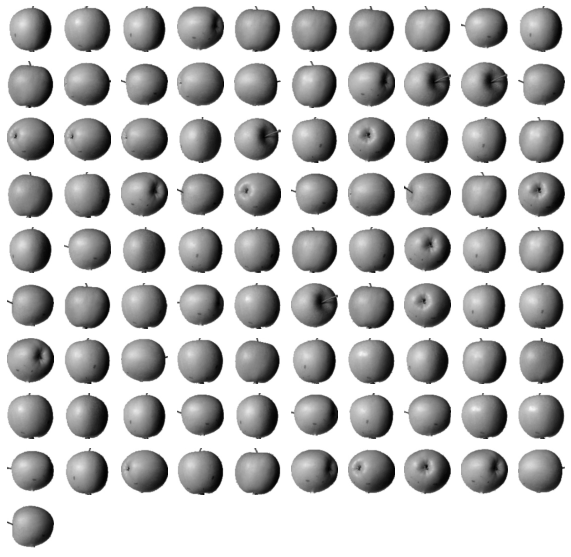

In [18]:
for label in range(0, 3):
    draw_fruits(fruits[km.labels_ == label])
    print("\n")

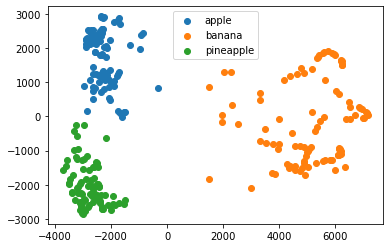

In [19]:
for label in range(0, 3):
    data = fruits_pca[km.labels_ == label]
    plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()

# 고객 세그먼테이션

## 데이터 가져오기

In [48]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel(io='./data/Online Retail.xlsx')
retail_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

## 데이터 정보 확인

In [49]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## 데이터 필터링

In [50]:
retail_df = retail_df[retail_df['Quantity'] > 0]
retail_df = retail_df[retail_df['UnitPrice'] > 0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## Country 데이터 확인

In [51]:
retail_df['Country'].value_counts()[:5]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Name: Country, dtype: int64

## 데이터 필터링

In [52]:
retail_df = retail_df[retail_df['Country']=='United Kingdom']
print(retail_df.shape)

(354321, 8)


## 데이터 가공

### 새로운 열을 생성하고 자료형 변경

In [53]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

### 구매횟수가 가장 많은 고객 5명의 구매 횟수와 구매 금액의 합계 출력

In [54]:
print(retail_df['CustomerID'].value_counts().head(5))
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64
CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


### 유일한 식별자 확인

In [55]:
retail_df.groupby(['InvoiceNo','StockCode'])['InvoiceNo'].count().mean()

1.028702077315023

### RDF 작업

In [56]:
# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()
aggregations = {
    'InvoiceDate': 'max',
    'InvoiceNo': 'count',
    'sale_amount':'sum'
}
cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'
                                   }
                        )
cust_df = cust_df.reset_index()
cust_df.head(3)

CustomerID             Recency  Frequency  Monetary
0       12346 2011-01-18 10:01:00          1  77183.60
1       12747 2011-12-07 14:34:00        103   4196.01
2       12748 2011-12-09 12:20:00       4595  33719.73

In [57]:
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days+1)
print('cust_df 로우와 컬럼 건수는 ',cust_df.shape)
cust_df.head(3)

cust_df 로우와 컬럼 건수는  (3920, 4)


CustomerID  Recency  Frequency  Monetary
0       12346      326          1  77183.60
1       12747        3        103   4196.01
2       12748        1       4595  33719.73

### 데이터 분포 파악

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

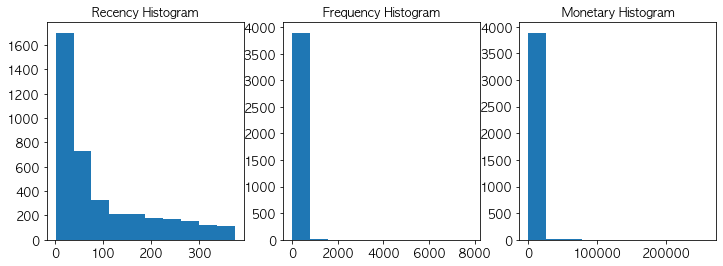

In [58]:
fig, (ax1,ax2,ax3) = plt.subplots(figsize=(12,4), nrows=1, ncols=3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

### 기술 통계량 확인

In [59]:
cust_df[['Recency','Frequency','Monetary']].describe()

Recency    Frequency       Monetary
count  3920.000000  3920.000000    3920.000000
mean     92.742092    90.388010    1864.385601
std      99.533485   217.808385    7482.817477
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     300.280000
50%      51.000000    41.000000     652.280000
75%     143.000000    99.250000    1576.585000
max     374.000000  7847.000000  259657.300000

## 알고리즘 수행

### 정규화 한 후 알고리즘 수행

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency','Frequency','Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.592


### 실루엣 계수를 시각화 해주는 함수

In [61]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성  
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

### 클러스터링 결과 시각화 함수

In [62]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화 
def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels
        
        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']
       
        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)           
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        axs[ind].legend(loc='upper right')
    
    plt.show()

### 실루엣 계수 와 클러스터링 결과 시각화

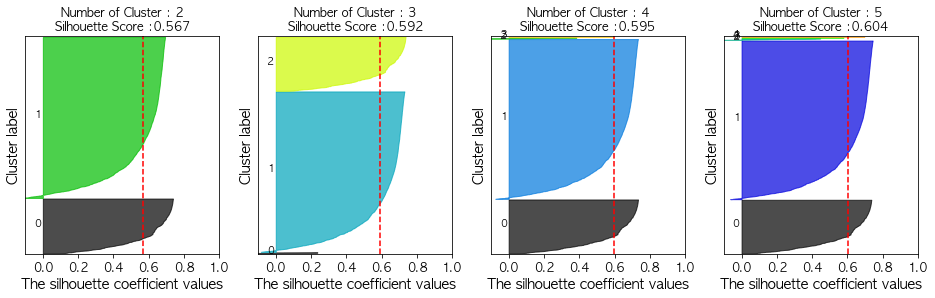

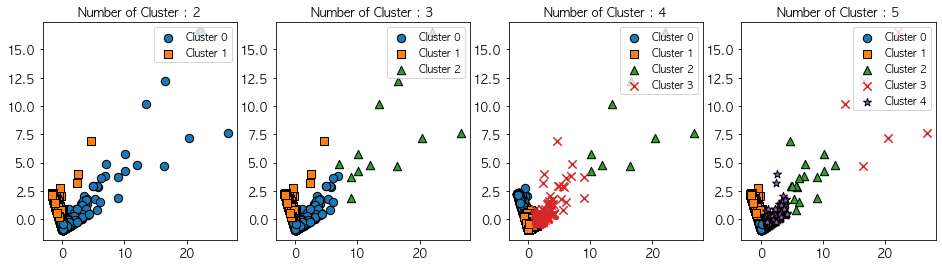

In [63]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

### 로그 변환 후 알고리즘 재 수행

In [64]:
### Log 변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

실루엣 스코어는 : 0.303


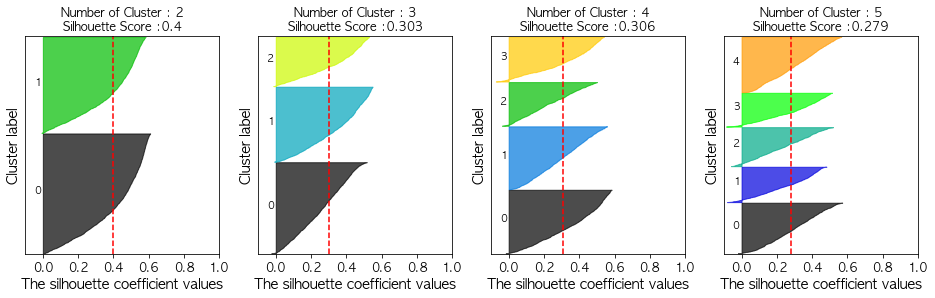

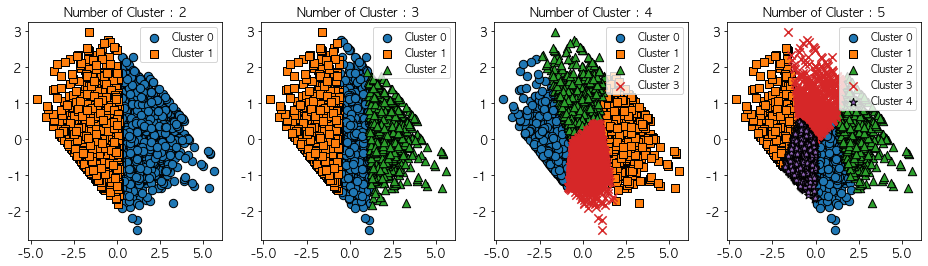

In [65]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

# 올리베타 얼굴 데이터셋 군집

In [66]:
import sys

# 사이킷런 ≥0.20 필수
import sklearn

# 공통 모듈 임포트
import numpy as np
import pandas as pd
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import platform
from matplotlib import font_manager, rc

#매킨토시의 경우
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
#윈도우의 경우
elif platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

mpl.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clusteringpractice"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
        
import warnings
warnings.filterwarnings(action='ignore')

## 데이터 가져오기

In [67]:
from sklearn.datasets import fetch_olivetti_faces

olivetti = fetch_olivetti_faces()

## 데이터 설명

In [68]:
print(olivetti.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   ===========

## 타겟 확인

In [69]:
olivetti.target

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11,
       11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15,
       15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18,
       18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22,
       22, 22, 22, 22, 22

## 데이터 계층적 샘플링

In [70]:
from sklearn.model_selection import StratifiedShuffleSplit

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=40, random_state=42)
train_valid_idx, test_idx = next(strat_split.split(olivetti.data, olivetti.target))
X_train_valid = olivetti.data[train_valid_idx]
y_train_valid = olivetti.target[train_valid_idx]
X_test = olivetti.data[test_idx]
y_test = olivetti.target[test_idx]

strat_split = StratifiedShuffleSplit(n_splits=1, test_size=80, random_state=43)
train_idx, valid_idx = next(strat_split.split(X_train_valid, y_train_valid))
X_train = X_train_valid[train_idx]
y_train = y_train_valid[train_idx]
X_valid = X_train_valid[valid_idx]
y_valid = y_train_valid[valid_idx]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(280, 4096) (280,)
(80, 4096) (80,)
(40, 4096) (40,)


## 차원 축소

In [71]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

199

## k-평균을 이용한 군집 - 클러스터 개수를 다양하게 설정

In [72]:
from sklearn.cluster import KMeans

k_range = range(5, 150, 5)
kmeans_per_k = []
for k in k_range:
    print("k={}".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_train_pca)
    kmeans_per_k.append(kmeans)

k=5
k=10
k=15
k=20
k=25
k=30
k=35
k=40
k=45
k=50
k=55
k=60
k=65
k=70
k=75
k=80
k=85
k=90
k=95
k=100
k=105
k=110
k=115
k=120
k=125
k=130
k=135
k=140
k=145


## 클러스터 개수에 따른 실루엣 계수 확인

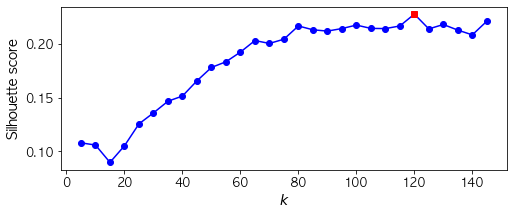

In [73]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X_train_pca, model.labels_)
                     for model in kmeans_per_k]
best_index = np.argmax(silhouette_scores)
best_k = k_range[best_index]
best_score = silhouette_scores[best_index]

plt.figure(figsize=(8, 3))
plt.plot(k_range, silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.plot(best_k, best_score, "rs")
plt.show()

## 이너셔 그래프

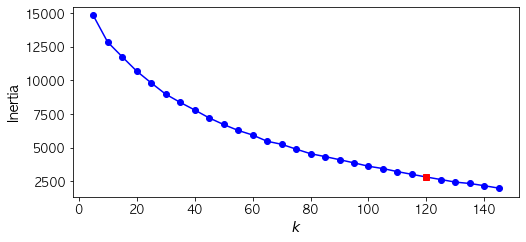

In [74]:
inertias = [model.inertia_ for model in kmeans_per_k]
best_inertia = inertias[best_index]

plt.figure(figsize=(8, 3.5))
plt.plot(k_range, inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.plot(best_k, best_inertia, "rs")
plt.show()

## 최적의 모델 찾기

In [75]:
best_model = kmeans_per_k[best_index]
print(best_model)

KMeans(n_clusters=120, random_state=42)


## 클러스터 시각화

Cluster 0


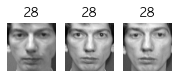

Cluster 1


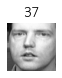

Cluster 2


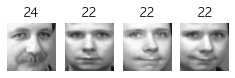

Cluster 3


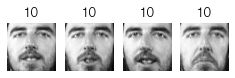

Cluster 4


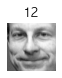

Cluster 5


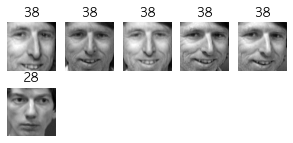

Cluster 6


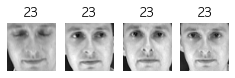

Cluster 7


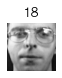

Cluster 8


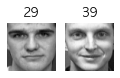

Cluster 9


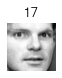

Cluster 10


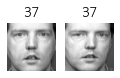

Cluster 11


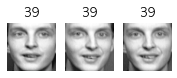

Cluster 12


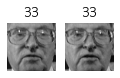

Cluster 13


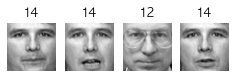

Cluster 14


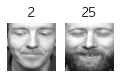

Cluster 15


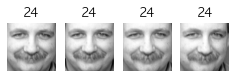

Cluster 16


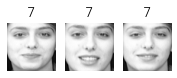

Cluster 17


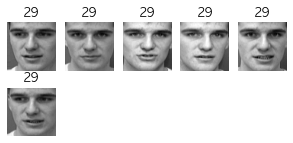

Cluster 18


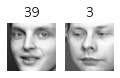

Cluster 19


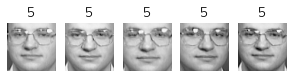

Cluster 20


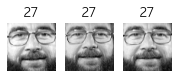

Cluster 21


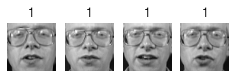

Cluster 22


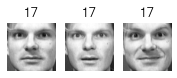

Cluster 23


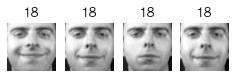

Cluster 24


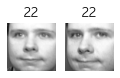

Cluster 25


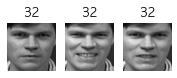

Cluster 26


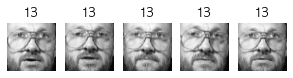

Cluster 27


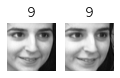

Cluster 28


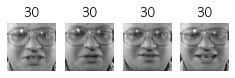

Cluster 29


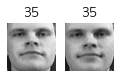

Cluster 30


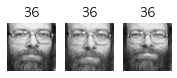

Cluster 31


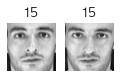

Cluster 32


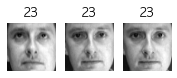

Cluster 33


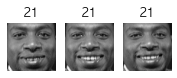

Cluster 34


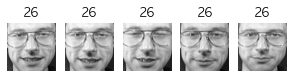

Cluster 35


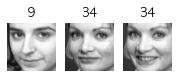

Cluster 36


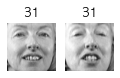

Cluster 37


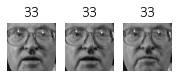

Cluster 38


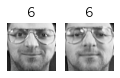

Cluster 39


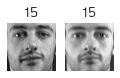

Cluster 40


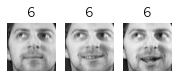

Cluster 41


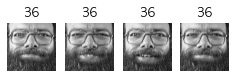

Cluster 42


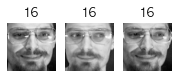

Cluster 43


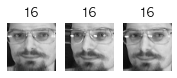

Cluster 44


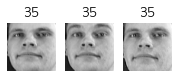

Cluster 45


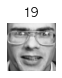

Cluster 46


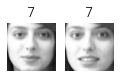

Cluster 47


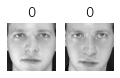

Cluster 48


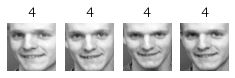

Cluster 49


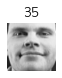

Cluster 50


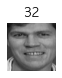

Cluster 51


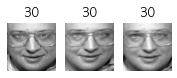

Cluster 52


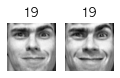

Cluster 53


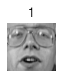

Cluster 54


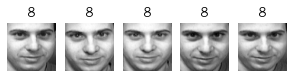

Cluster 55


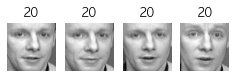

Cluster 56


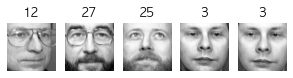

Cluster 57


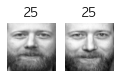

Cluster 58


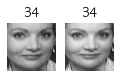

Cluster 59


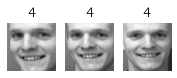

Cluster 60


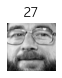

Cluster 61


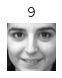

Cluster 62


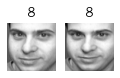

Cluster 63


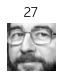

Cluster 64


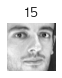

Cluster 65


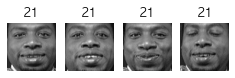

Cluster 66


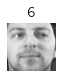

Cluster 67


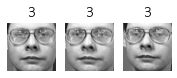

Cluster 68


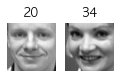

Cluster 69


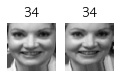

Cluster 70


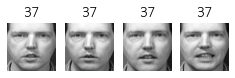

Cluster 71


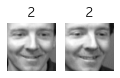

Cluster 72


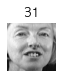

Cluster 73


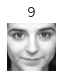

Cluster 74


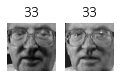

Cluster 75


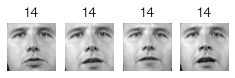

Cluster 76


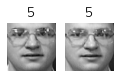

Cluster 77


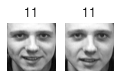

Cluster 78


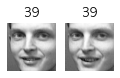

Cluster 79


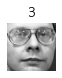

Cluster 80


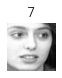

Cluster 81


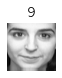

Cluster 82


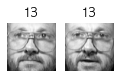

Cluster 83


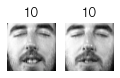

Cluster 84


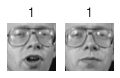

Cluster 85


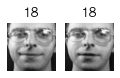

Cluster 86


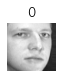

Cluster 87


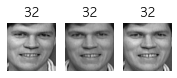

Cluster 88


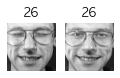

Cluster 89


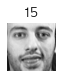

Cluster 90


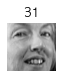

Cluster 91


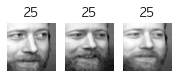

Cluster 92


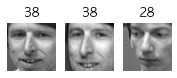

Cluster 93


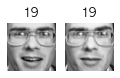

Cluster 94


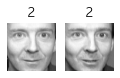

Cluster 95


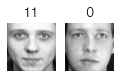

Cluster 96


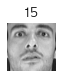

Cluster 97


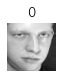

Cluster 98


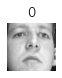

Cluster 99


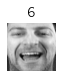

Cluster 100


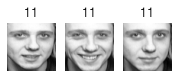

Cluster 101


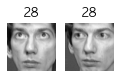

Cluster 102


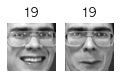

Cluster 103


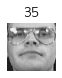

Cluster 104


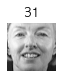

Cluster 105


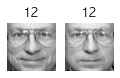

Cluster 106


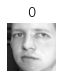

Cluster 107


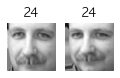

Cluster 108


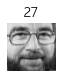

Cluster 109


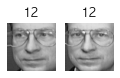

Cluster 110


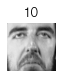

Cluster 111


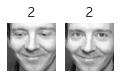

Cluster 112


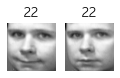

Cluster 113


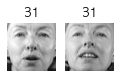

Cluster 114


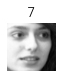

Cluster 115


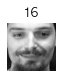

Cluster 116


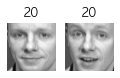

Cluster 117


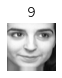

Cluster 118


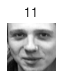

Cluster 119


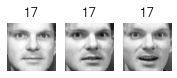

In [76]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

for cluster_id in np.unique(best_model.labels_):
    print("Cluster", cluster_id)
    in_cluster = best_model.labels_==cluster_id
    faces = X_train[in_cluster]
    labels = y_train[in_cluster]
    plot_faces(faces, labels)

## 군집으로 전처리

### 분류기를 이용해서 예측

In [77]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_pca, y_train)
clf.score(X_valid_pca, y_valid)

0.9

### k-평균을 차원 축소 도구로 사용하여 축소된 세트에서 분류기를 훈련

In [78]:
X_train_reduced = best_model.transform(X_train_pca)
X_valid_reduced = best_model.transform(X_valid_pca)
X_test_reduced = best_model.transform(X_test_pca)

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_reduced, y_train)
    
clf.score(X_valid_reduced, y_valid)

0.7

### 결과 해석
전혀 좋아지지 않았기 때문에 클러스터 개수를 튜닝
### GridSearchCV를 사용할 수 있지만 검증 세트가 이미 있기 때문에 K-폴드 교차 검증을 할 필요가 없고 하나의 하이퍼파라미터만 탐색하기 때문에 간단히 직접 반복문을 이용해서 구현        

In [79]:
from sklearn.pipeline import Pipeline

for n_clusters in k_range:
    pipeline = Pipeline([
        ("kmeans", KMeans(n_clusters=n_clusters, random_state=42)),
        ("forest_clf", RandomForestClassifier(n_estimators=150, random_state=42))
    ])
    pipeline.fit(X_train_pca, y_train)
    print(n_clusters, pipeline.score(X_valid_pca, y_valid))

5 0.3875
10 0.575
15 0.6
20 0.6625
25 0.6625
30 0.6625
35 0.675
40 0.75
45 0.7375
50 0.725
55 0.7125
60 0.7125
65 0.7375
70 0.7375
75 0.7375
80 0.7875
85 0.7625
90 0.75
95 0.7125
100 0.775
105 0.75
110 0.725
115 0.7625
120 0.7
125 0.75
130 0.725
135 0.7375
140 0.7625
145 0.6875


### 결과 해석
클러스터 개수를 튜닝해도 80% 정확도를 넘지 못함 클러스터 센트로이드까지 거리는 원본 이미지만큼 유용하지 않은 것 같음

### 축소된 세트에서 추출한 특성을 원본 특성에 추가

In [80]:
X_train_extended = np.c_[X_train_pca, X_train_reduced]
X_valid_extended = np.c_[X_valid_pca, X_valid_reduced]
X_test_extended = np.c_[X_test_pca, X_test_reduced]

clf = RandomForestClassifier(n_estimators=150, random_state=42)
clf.fit(X_train_extended, y_train)
clf.score(X_valid_extended, y_valid)

0.8125

## 가우시안 혼합 모델 사용

### 가우시안 모델 훈련

In [81]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=40, random_state=42)
y_pred = gm.fit_predict(X_train_pca)

### 이 모델을 사용해(sample() 메서드로) 새로운 얼굴을 생성하고 시각화
### PCA를 사용했다면 inverse_transform() 메서드를 사용해야 함

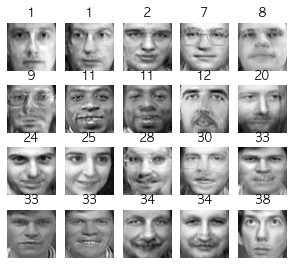

In [82]:
n_gen_faces = 20
gen_faces_reduced, y_gen_faces = gm.sample(n_samples=n_gen_faces)
gen_faces = pca.inverse_transform(gen_faces_reduced)

plot_faces(gen_faces, y_gen_faces)

### 이미지 수정

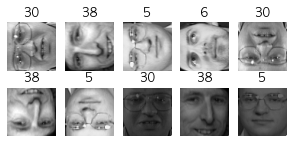

In [83]:
n_rotated = 4
rotated = np.transpose(X_train[:n_rotated].reshape(-1, 64, 64), axes=[0, 2, 1])
rotated = rotated.reshape(-1, 64*64)
y_rotated = y_train[:n_rotated]

n_flipped = 3
flipped = X_train[:n_flipped].reshape(-1, 64, 64)[:, ::-1]
flipped = flipped.reshape(-1, 64*64)
y_flipped = y_train[:n_flipped]

n_darkened = 3
darkened = X_train[:n_darkened].copy()
darkened[:, 1:-1] *= 0.3
y_darkened = y_train[:n_darkened]

X_bad_faces = np.r_[rotated, flipped, darkened]
y_bad = np.concatenate([y_rotated, y_flipped, y_darkened])

plot_faces(X_bad_faces, y_bad)

### 변경한 데이터 와 이전 데이터 score 확인
#### 잘못된 사진은 이 가우시안 혼합 모델에서 등장할 가능성이 매우 낮음
#### 다른 훈련 샘플의 점수와 비교

In [84]:
X_bad_faces_pca = pca.transform(X_bad_faces)
gm.score_samples(X_bad_faces_pca)

array([-2.43643238e+07, -1.89785066e+07, -3.78112309e+07, -4.98187666e+07,
       -3.20479295e+07, -1.37530926e+07, -2.92374127e+07, -1.05489113e+08,
       -1.19575471e+08, -6.74257051e+07])

In [85]:
gm.score_samples(X_train_pca[:10])

array([1163.02020802, 1134.03638016, 1156.32132785, 1170.6760278 ,
       1141.45404859, 1154.35205168, 1091.32894564, 1111.41149542,
       1096.43049066, 1132.98982589])

### 차원 축소를 이상치 탐지에 이용

### 축소된 이미지

In [86]:
X_train_pca

array([[ 3.78081584e+00, -1.85477579e+00, -5.14402580e+00, ...,
        -1.35641083e-01, -2.14069068e-01,  6.11860305e-02],
       [ 1.01488495e+01, -1.52754033e+00, -7.66988456e-01, ...,
         1.23930134e-01, -1.35273740e-01, -2.32684407e-02],
       [-1.00152874e+01,  2.87729359e+00, -9.19888377e-01, ...,
         7.26140663e-02, -2.96539254e-03,  1.24884278e-01],
       ...,
       [ 2.47586823e+00,  2.95597291e+00,  1.29985106e+00, ...,
        -2.09059026e-02,  3.48681323e-02, -1.54332668e-01],
       [-3.22032094e+00,  5.34897900e+00,  1.39426935e+00, ...,
         5.75391091e-02, -2.28321195e-01,  1.55569628e-01],
       [-9.22876894e-01, -3.64702988e+00,  2.26088190e+00, ...,
         1.36849329e-01, -6.91437572e-02,  6.26967847e-02]], dtype=float32)

### 재구성 오차를 출력해주는 함수

In [87]:
def reconstruction_errors(pca, X):
    X_pca = pca.transform(X)
    X_reconstructed = pca.inverse_transform(X_pca)
    mse = np.square(X_reconstructed - X).mean(axis=-1)
    return mse

### 축소된 데이터의 오차 확인

In [88]:
reconstruction_errors(pca, X_train).mean()

0.00019205351

### 수정된 이미지의 오차 확인

In [89]:
reconstruction_errors(pca, X_bad_faces).mean()

0.004707354

### 수정된 이미지 출력

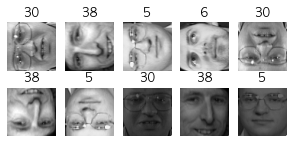

In [90]:
plot_faces(X_bad_faces, y_bad)

### 수정된 이미지를 재구성해서 출력

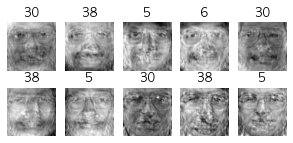

In [91]:
X_bad_faces_reconstructed = pca.inverse_transform(X_bad_faces_pca)
plot_faces(X_bad_faces_reconstructed, y_bad)